In [ ]:
# lpr_scregseg environment

# Preprocess Swanson et al, 2021. PBMC Multiome data whole (permeabilized) cells (perm_cells)

Aim: Derive identical feature set for additional ATAC data from other studies as for treatment-control use case.

Keep preprocessing as similar as possible to original publication (Swanson et al., 2021):

GEX: 
"Filtering was performed to remove low-quality barcodes and putative doublets. For transcription (RNA-seq data), we filtered barcodes based on number of genes detected per barcode: ... permeabilized cells on 10x Multiome: >300 genes, <2,750,750 genes, 8334 barcodes retained; ..."

This must be number of UMIs instead of number of genes, as otherwise we can't retain a similar number of cells as reported in the publiation.

We retain cells with >300  <2,750,750 UMIs.

ATAC:
"For accessibility (ATAC-seq data), barcodes were filtered using the same criteria as other scATAC-seq libraries, above (>1,000,000 unique fragments, FRIP > 0.2, FRITSS > 0.2, Fraction ENCODE overlap > 0.5), and doublets were removed using the ArchR package (Granja et al., 2020): ... permeabilized cells on 10x Multiome: 7238 barcodes retained; ..."

? Threshold doublets?


In [1]:
import os
import pandas as pd
from anndata import read_h5ad
import scanpy as sc
import scregseg
import matplotlib.pyplot as plt
import numpy as np

## Swanson2021 - PBMC Multiome data whole (permeabilized) cells (perm_cells)

In [2]:
## ATAC preprocessing - derive same feature set as in treatment-control use case

In [3]:
wd = "liam_manuscript_reproducibility/data/original/Swanson2021/perm_cells/"

In [4]:
! ls -l liam_manuscript_reproducibility/data/original/Swanson2021/perm_cells

total 499456
-rw-r--r-- 1 prauten AG_Ohler 425162502 Mar  2  2021 GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_atac_filtered_fragments.tsv.gz
-rw-r--r-- 1 prauten AG_Ohler    729854 Mar  2  2021 GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_atac_filtered_metadata.csv.gz
-rw-r--r-- 1 prauten AG_Ohler  63284073 Mar  2  2021 GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_cellranger-arc_filtered_feature_bc_matrix.h5
-rw-r--r-- 1 prauten AG_Ohler  22207386 Mar  2  2021 GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_cellranger-arc_per_barcode_metrics.csv.gz


In [5]:
!scregseg fragments_to_counts \
          --fragmentfile liam_manuscript_reproducibility/data/original/Swanson2021/perm_cells/GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_atac_filtered_fragments.tsv.gz \
          --regions liam_manuscript_reproducibility/data/derived/Mimitou2021/ATAC/all_datasets_informative_rarest_states_out_of_50.bed \
          --with-fraglen \
          --counts liam_manuscript_reproducibility/data/derived/Swanson2021/perm_cells/countmatrix_perm_cells_informative_rarest_states_out_of_50_0.h5ad

***** WARNING: File /fast/AG_Ohler/prauten/projects/github/Liam_paper_reproducibility/data/original/Swanson2021/perm_cells/GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_atac_filtered_fragments.tsv.gz has inconsistent naming convention for record:
GL000009.2	19143	19179	f62a9b083f0511ebba2f42010a19c80f	1

***** WARNING: File /fast/AG_Ohler/prauten/projects/github/Liam_paper_reproducibility/data/original/Swanson2021/perm_cells/GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_atac_filtered_fragments.tsv.gz has inconsistent naming convention for record:
GL000009.2	19143	19179	f62a9b083f0511ebba2f42010a19c80f	1

***** WARNING: File /fast/AG_Ohler/prauten/projects/github/Liam_paper_reproducibility/data/original/Swanson2021/perm_cells/GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_atac_filtered_fragments.tsv.gz has inconsistent naming convention for record:
GL000009.2	19143	19179	f62a9b083f0511ebba2f42010a19c80f	1

***** WARNING: File /fast/AG_Ohler/prauten/pro

In [6]:
# Load cell ranger meta data (10x pipeline)
cellranger_metadata = pd.read_csv(wd + 'GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_cellranger-arc_per_barcode_metrics.csv.gz')

In [7]:
# Keep only barcodes that were called as cells by 10x pipeline
cellranger_metadata = cellranger_metadata[cellranger_metadata.is_cell==1]

## ATAC filtering from Swanson et al, 2021 publication
> (>1,000,000 unique fragments, FRIP > 0.2, FRITSS > 0.2, Fraction ENCODE overlap > 0.5), and doublets were removed using the ArchR package (Granja et al., 2020)

I could not identify column for: Fraction ENCODE overlap > 0.5

\>1,000,000 unique fragments must be before before filtering/further preprocessing. If we apply this criterion on the meta data file, we retain NO cells.

All cells in meta data file fulfil FRIP > 0.2, FRITSS > 0.2 criteria

Thresdhold for ArchR doublet is not reported, I chose < 1 to match the reported final cell number as closely as possible.

In [8]:
tea_seq_metadata = pd.read_csv(wd + 'GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_atac_filtered_metadata.csv.gz')

In [9]:
tea_seq_metadata[tea_seq_metadata['n_fragments'] > 1000000]

,original_barcodes,n_fragments,n_duplicate,n_mito,n_unique,altius_count,altius_frac,gene_bodies_count,gene_bodies_frac,peaks_count,...,tss_frac,barcodes,cell_name,well_id,chip_id,batch_id,pbmc_sample_id,DoubletScore,DoubletEnrichment,TSSEnrichment


In [10]:
tea_seq_metadata[tea_seq_metadata['n_unique'] > 1000000]

,original_barcodes,n_fragments,n_duplicate,n_mito,n_unique,altius_count,altius_frac,gene_bodies_count,gene_bodies_frac,peaks_count,...,tss_frac,barcodes,cell_name,well_id,chip_id,batch_id,pbmc_sample_id,DoubletScore,DoubletEnrichment,TSSEnrichment


In [11]:
tea_seq_metadata.shape[0]

7854

In [12]:
tea_seq_metadata[tea_seq_metadata['tss_frac'] > 0.2].shape[0]

7854

In [13]:
tea_seq_metadata[tea_seq_metadata['peaks_frac'] > 0.2].shape[0]

7854

In [14]:
# -> FRIP > 0.2, FRITSS > 0.2 criteria fulfiled

<AxesSubplot:>

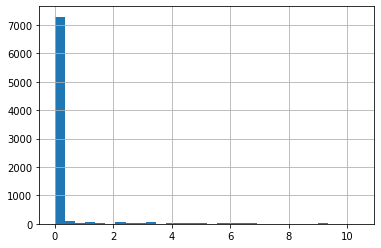

In [15]:
tea_seq_metadata['DoubletScore'].hist(bins=30)

In [16]:
tea_seq_metadata['DoubletScore'].value_counts()

0.000000     7290
0.403376       49
1.339812       39
2.096362       36
0.629579       32
1.586920       29
3.174727       29
2.625765       28
2.358594       27
4.033991       25
0.861089       25
1.097851       23
2.897826       22
4.329776       19
3.456420       19
4.630166       18
6.199649       16
4.935117       15
5.558523       14
6.858163       14
6.526753       12
9.295311       11
9.659780        9
5.244583        9
8.934846        8
7.533740        8
7.877830        7
10.028216       7
7.193838        6
8.578420        5
10.400585       3
Name: DoubletScore, dtype: int64

In [17]:
tea_seq_metadata = tea_seq_metadata[tea_seq_metadata['DoubletScore'] < 1]

In [18]:
qcontrolled_cells_Multiome_perm_cells = cellranger_metadata.merge(tea_seq_metadata, left_on="gex_barcode", right_on="original_barcodes")["barcodes"]

In [19]:
qcontrolled_cells_Multiome_perm_cells.to_csv('liam_manuscript_reproducibility/data/derived/Swanson2021/perm_cells/' + 'qcontrolled_cells_Multiome_perm_cells.csv', index=False)

In [20]:
print(f'{qcontrolled_cells_Multiome_perm_cells.shape[0]} high-quality cells are left for downstream processing')


7269 high-quality cells are left for downstream processing


In [21]:
# 128G
!scregseg subset \
          --incounts liam_manuscript_reproducibility/data/derived/Swanson2021/perm_cells/countmatrix_perm_cells_informative_rarest_states_out_of_50_0.h5ad \
          --outcounts liam_manuscript_reproducibility/data/derived/Swanson2021/perm_cells/filtered_countmatrix_perm_cells_informative_rarest_states_out_of_50_0.h5ad \
          --subset liam_manuscript_reproducibility/data/derived/Swanson2021/perm_cells/qcontrolled_cells_Multiome_perm_cells.csv